###  CapsNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale images to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape images to (batch_size, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import urllib.request

# URL to download the MNIST dataset
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
file_path = 'mnist.npz'

# Download the dataset
urllib.request.urlretrieve(url, file_path)

# Check if the file has been downloaded successfully
import os
if os.path.exists(file_path):
    print(f"File {file_path} has been downloaded successfully.")
else:
    print(f"File {file_path} does not exist.")



File mnist.npz has been downloaded successfully.


In [ ]:
import numpy as np

# Load the MNIST dataset
data = np.load(file_path)

# Check the keys in the dataset
print(f"Keys in the dataset: {data.files}")

# Extract the data
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

# Check the shape of the data to ensure it's loaded correctly
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")


Keys in the dataset: ['x_test', 'x_train', 'y_train', 'y_test']
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

class CapsLayer(layers.Layer):
    def __init__(self, num_outputs, vec_len, layer_type='CONV', **kwargs):
        super(CapsLayer, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.vec_len = vec_len
        self.layer_type = layer_type

    def build(self, input_shape):
        if self.layer_type == 'CONV':
            self.kernel = self.add_weight(
                name='kernel',
                shape=(9, 9, input_shape[-1], self.vec_len * self.num_outputs),
                initializer='glorot_uniform',
                trainable=True
            )
        elif self.layer_type == 'FC':
            self.fc_kernel = self.add_weight(
                name='fc_kernel',
                shape=(input_shape[-1], self.num_outputs * self.vec_len),
                initializer='glorot_uniform',
                trainable=True
            )

    def call(self, inputs):
        if self.layer_type == 'CONV':
            conv = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='VALID')
            capsules = tf.reshape(conv, [-1, conv.shape[1] * conv.shape[2] * self.num_outputs, self.vec_len])
        elif self.layer_type == 'FC':
            capsules = tf.matmul(inputs, self.fc_kernel)
            capsules = tf.reshape(capsules, [-1, self.num_outputs, self.vec_len])
        return capsules

    def compute_output_shape(self, input_shape):
        if self.layer_type == 'CONV':
            conv_output_shape = (
                input_shape[0],
                (input_shape[1] - 9 + 1) // 1,
                (input_shape[2] - 9 + 1) // 1,
                self.num_outputs * self.vec_len
            )
            return (conv_output_shape[0], conv_output_shape[1] * conv_output_shape[2] * self.num_outputs, self.vec_len)
        elif self.layer_type == 'FC':
            return (input_shape[0], self.num_outputs, self.vec_len)

class CapsNet(tf.keras.Model):
    def __init__(self, num_classes=10, **kwargs):
        super(CapsNet, self).__init__(**kwargs)
        self.num_classes = num_classes

        self.conv1 = layers.Conv2D(256, kernel_size=9, strides=1, padding='valid', activation='relu')
        self.primary_caps = CapsLayer(num_outputs=32, vec_len=8, layer_type='CONV')
        self.digit_caps = CapsLayer(num_outputs=num_classes, vec_len=16, layer_type='FC')
        self.decoder = models.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(1024, activation='relu'),
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.primary_caps(x)
        x = self.digit_caps(x)
        decoded = self.decoder(tf.reshape(x, (-1, self.num_classes * 16)))
        return decoded

    def build(self, input_shape):
        self.conv1.build(input_shape)
        self.primary_caps.build(self.conv1.compute_output_shape(input_shape))
        self.digit_caps.build(self.primary_caps.compute_output_shape(self.conv1.compute_output_shape(input_shape)))
        self.decoder.build((None, self.num_classes * 16))
        super(CapsNet, self).build(input_shape)

def margin_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    m_plus = 0.9
    m_minus = 0.1
    loss = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) + 0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

inputs = layers.Input(shape=(28, 28, 1))
model = CapsNet(num_classes=10)(inputs)
final_model = tf.keras.Model(inputs=inputs, outputs=model)
final_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
final_model.summary()

# Assuming you have the MNIST dataset, you can now train the model.
# Uncomment the lines below to load the MNIST data and train the model.

# Load the MNIST dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
# x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0
# x_test = np.expand_dims(x_test, -1).astype('float32') / 255.0

# One-hot encode the labels
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Train the model
# final_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ caps_net_1 (CapsNet)                 │ (None, 28, 28, 1)           │       6,742,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,742,032 (25.72 MB)

 Trainable params: 6,742,032 (25.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

class CapsNetWithOutput(models.Model):
    def __init__(self, num_classes=10):
        super(CapsNetWithOutput, self).__init__()

        # Define the Conv2D layer
        self.conv1 = layers.Conv2D(256, (9, 9), strides=(1, 1), padding='valid', activation='relu')

        # Define the CapsLayer
        self.caps_layer = CapsLayer(num_outputs=10, vec_len=8, num_routing=3)

        # Flatten the capsule output to feed into a Dense layer for classification
        self.flatten = layers.Flatten()

        # Dense layer for final classification (10 classes)
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply Conv2D
        x = self.conv1(inputs)

        # Pass through the Capsule Layer
        x = self.caps_layer(x)

        # Flatten the capsule output
        x = self.flatten(x)

        # Pass through the Dense layer for classification
        x = self.dense(x)

        return x


In [2]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np

class CapsLayer(layers.Layer):
    def __init__(self, num_outputs, vec_len, layer_type='CONV', **kwargs):
        super(CapsLayer, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.vec_len = vec_len
        self.layer_type = layer_type

    def build(self, input_shape):
        if self.layer_type == 'CONV':
            self.kernel = self.add_weight(
                name='kernel',
                shape=(9, 9, input_shape[-1], self.vec_len * self.num_outputs),
                initializer='glorot_uniform',
                trainable=True
            )
        elif self.layer_type == 'FC':
            self.fc_kernel = self.add_weight(
                name='fc_kernel',
                shape=(input_shape[-1], self.num_outputs * self.vec_len),
                initializer='glorot_uniform',
                trainable=True
            )

    def call(self, inputs):
        if self.layer_type == 'CONV':
            conv = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='VALID')
            capsules = tf.reshape(conv, [-1, conv.shape[1] * conv.shape[2] * self.num_outputs, self.vec_len])
        elif self.layer_type == 'FC':
            capsules = tf.matmul(inputs, self.fc_kernel)
            capsules = tf.reshape(capsules, [-1, self.num_outputs, self.vec_len])
        return capsules

    def compute_output_shape(self, input_shape):
        if self.layer_type == 'CONV':
            conv_output_shape = (
                input_shape[0],
                (input_shape[1] - 9 + 1) // 1,
                (input_shape[2] - 9 + 1) // 1,
                self.num_outputs * self.vec_len
            )
            return (conv_output_shape[0], conv_output_shape[1] * conv_output_shape[2] * self.num_outputs, self.vec_len)
        elif self.layer_type == 'FC':
            return (input_shape[0], self.num_outputs, self.vec_len)

class CapsNetWithOutput(models.Model):
    def __init__(self, num_classes=10):
        super(CapsNetWithOutput, self).__init__()

        self.conv1 = layers.Conv2D(256, (9, 9), strides=(1, 1), padding='valid', activation='relu')
        self.caps_layer = CapsLayer(num_outputs=10, vec_len=8)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.caps_layer(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

# Assuming you have preprocessed data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Expand dimensions to include channel (1 for grayscale images)
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

# Convert to float32
x_train = x_train.numpy().astype('float32') / 255.0
x_test = x_test.numpy().astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Create and compile the model
model = CapsNetWithOutput(num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2877s 3s/step - accuracy: 0.9282 - loss: 0.2299 - val_accuracy: 0.9762 - val_loss: 0.0743
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2836s 3s/step - accuracy: 0.9790 - loss: 0.0677 - val_accuracy: 0.9877 - val_loss: 0.0402
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2895s 3s/step - accuracy: 0.9847 - loss: 0.0502 - val_accuracy: 0.9836 - val_loss: 0.0560
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2823s 3s/step - accuracy: 0.9870 - loss: 0.0447 - val_accuracy: 0.9861 - val_loss: 0.0501
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2797s 3s/step - accuracy: 0.9886 - loss: 0.0400 - val_accuracy: 0.9830 - val_loss: 0.0680
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2776s 3s/step - accuracy: 0.9890 - loss: 0.0375 - val_accuracy: 0.9852 - val_loss: 0.0526
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2762s 3s/step - accuracy: 0.9912 - loss: 0.0308 - val_accuracy: 0.9842 - val_loss: 0.0590
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━

In [3]:
 test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 325ms/step - accuracy: 0.9783 - loss: 0.1005
Test Loss: 0.0883946567773819
Test Accuracy: 0.9815999865531921


In [4]:
# Save the trained model to a file
model.save('capsnet_mnist_model.h5')


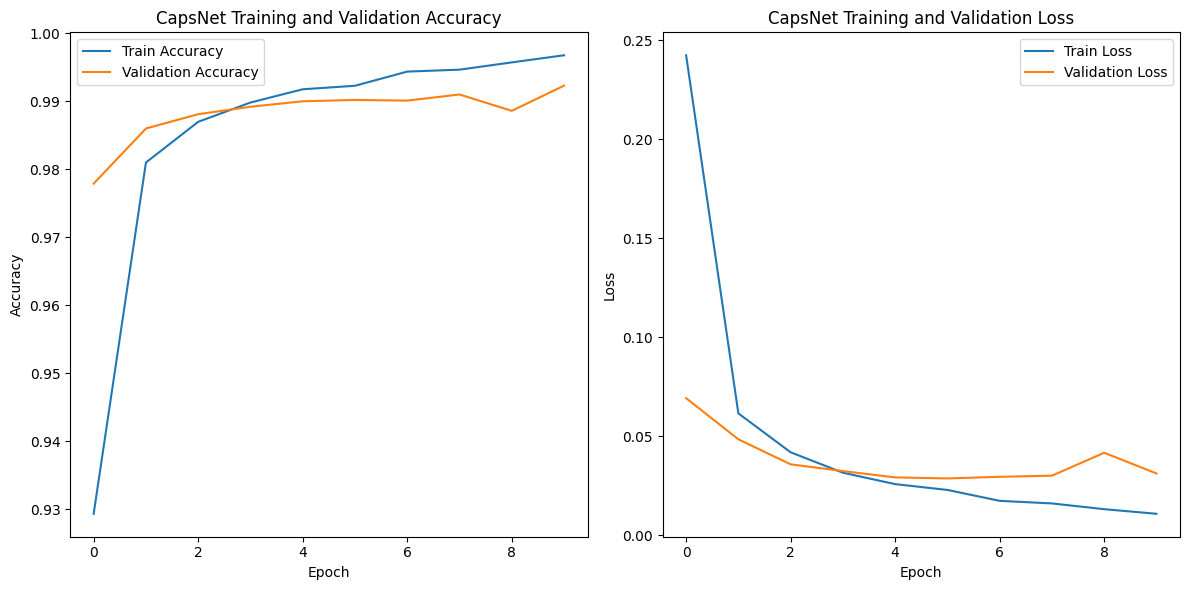

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CapsNet Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CapsNet Training and Validation Loss')

plt.tight_layout()
plt.show()


In [6]:
def visualize_predictions(model, x_test, y_test, num_images=10):
    predictions = model.predict(x_test[:num_images])  # Get predictions for a few images
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[:num_images], axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap='gray')  # Remove channel dimension for grayscale display
        plt.title(f"Pred: {predicted_labels[i]} (True: {true_labels[i]})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


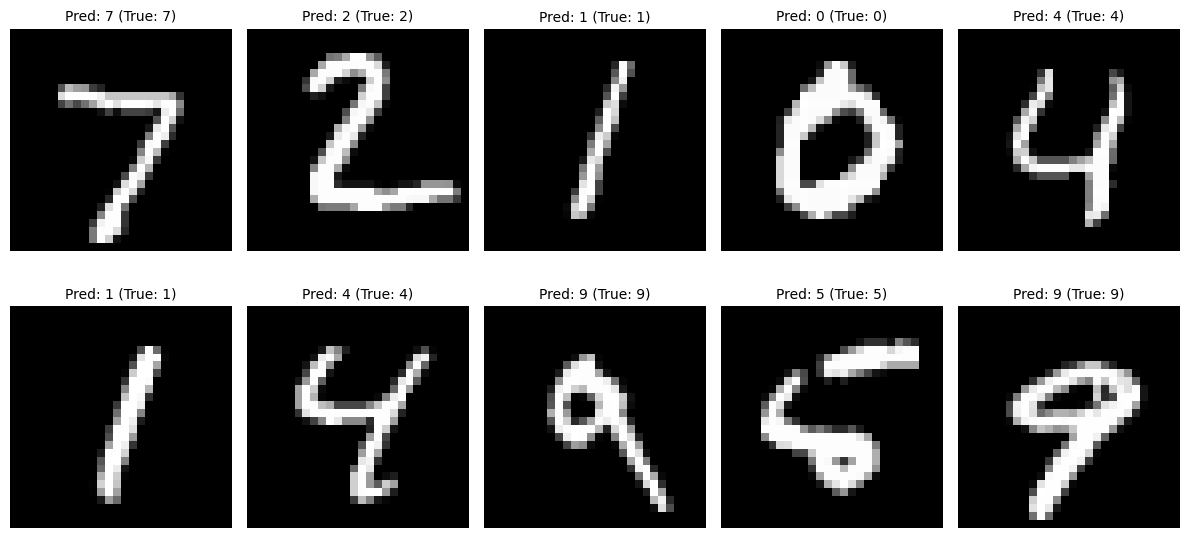

In [29]:
# Visualize predictions for the first 10 test images
visualize_predictions(model, x_test, y_test, num_images=10)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


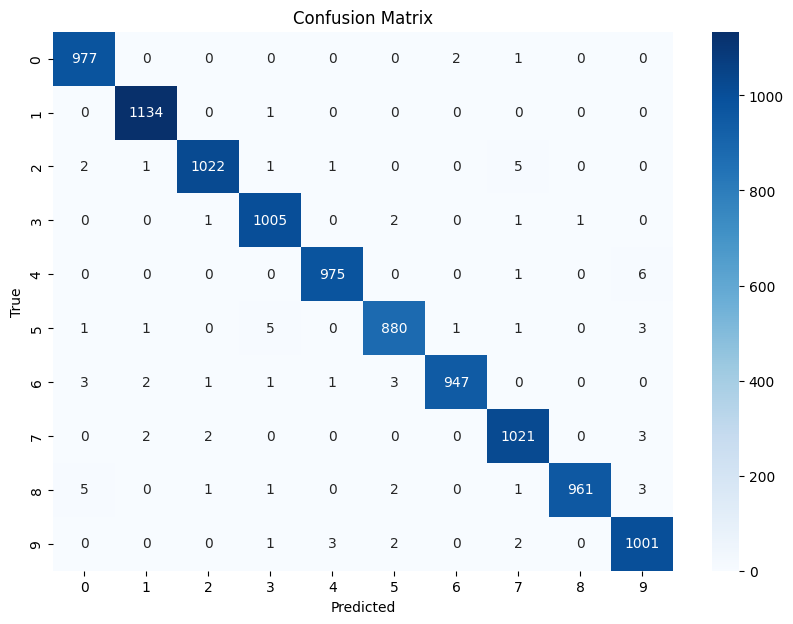

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### CNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.8338 - loss: 0.5600 - val_accuracy: 0.9774 - val_loss: 0.0702
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 128ms/step - accuracy: 0.9810 - loss: 0.0638 - val_accuracy: 0.9871 - val_loss: 0.0370
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - accuracy: 0.9866 - loss: 0.0424 - val_accuracy: 0.9866 - val_loss: 0.0447
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.9900 - loss: 0.0313 - val_accuracy: 0.9866 - val_loss: 0.0390
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.9921 - loss: 0.0260 - val_accuracy: 0.9893 - val_loss: 0.0334
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 123ms/step - accuracy: 0.9931 - loss: 0.0201 - val_accuracy: 0.9883 - val_loss: 0.0340
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 125ms/step - accuracy: 0.9944 - loss: 0.0184 - val_accuracy: 0.9929 - val_loss: 0.0227
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 138ms/step - accuracy: 0.9945 - loss: 0

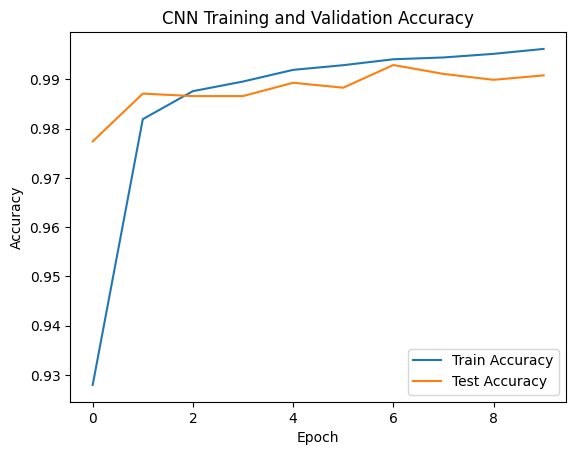

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1) / 255.0  # Normalize and reshape to (28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1) / 255.0

y_train = to_categorical(y_train, 10)  # One-hot encode labels
y_test = to_categorical(y_test, 10)

# Define the CNN model (now named cnn_model)
cnn_model = models.Sequential()

# Convolutional Layer 1
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output for fully connected layers
cnn_model.add(layers.Flatten())

# Fully connected layer
cnn_model.add(layers.Dense(64, activation='relu'))

# Output layer
cnn_model.add(layers.Dense(10, activation='softmax'))

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
history_cnn = cnn_model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the CNN model on the test data
y_pred_cnn = cnn_model.predict(x_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)  # Get the predicted class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Calculate accuracy, precision, recall, and F1-score for CNN
accuracy_cnn = accuracy_score(y_true, y_pred_classes_cnn)
precision_cnn = precision_score(y_true, y_pred_classes_cnn, average='weighted')
recall_cnn = recall_score(y_true, y_pred_classes_cnn, average='weighted')
f1_cnn = f1_score(y_true, y_pred_classes_cnn, average='weighted')

# Print the results for CNN
print(f'CNN Accuracy: {accuracy_cnn * 100:.2f}%')
print(f'CNN Precision (Avg.): {precision_cnn * 100:.2f}%')
print(f'CNN Recall (Avg.): {recall_cnn * 100:.2f}%')
print(f'CNN F1-Score (Avg.): {f1_cnn * 100:.2f}%')

# Optionally, plot training history (accuracy and loss for CNN)
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Training and Validation Accuracy')
plt.show()


In [35]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,968 (1.07 MB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,646 (729.09 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


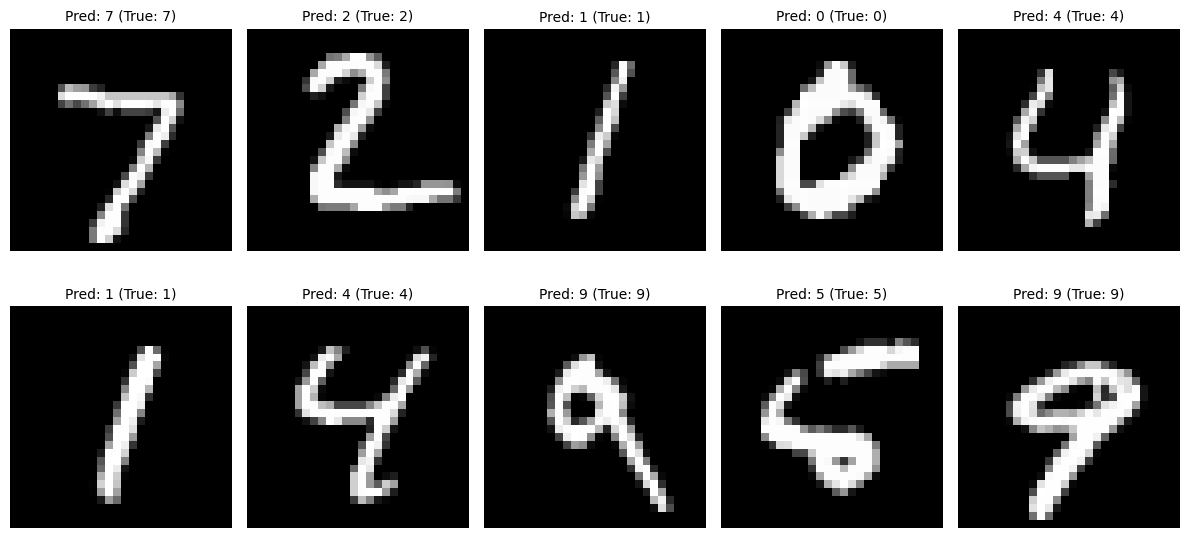

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(cnn_model, x_test, y_test, num_images=10):
    # Get predictions for the first 'num_images' test images
    predictions = cnn_model.predict(x_test[:num_images])
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels
    true_labels = np.argmax(y_test[:num_images], axis=1)  # True labels

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap='gray')  # Remove channel dimension for grayscale display
        plt.title(f"Pred: {predicted_labels[i]} (True: {true_labels[i]})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions for CNN
visualize_predictions(cnn_model, x_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


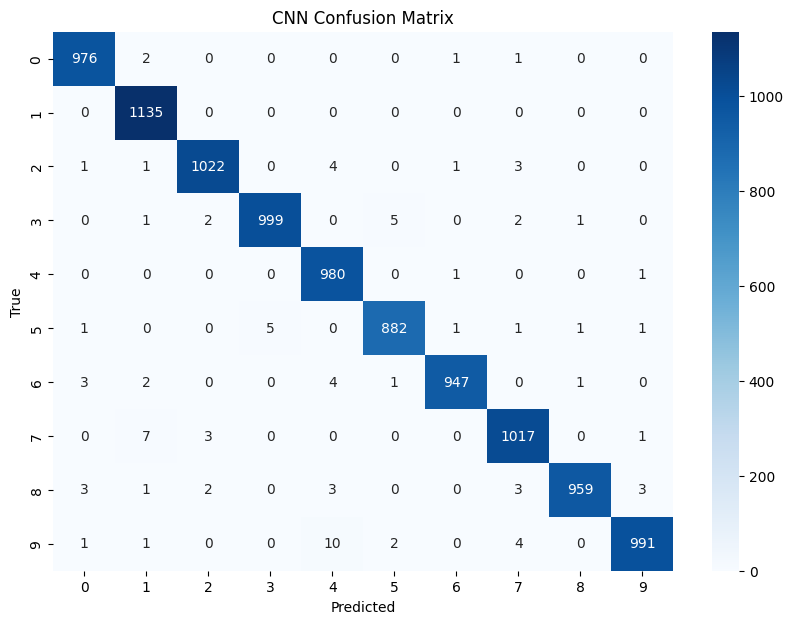

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict with the CNN model
y_pred = cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()


COMPARING CNN AND CAPSNET

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


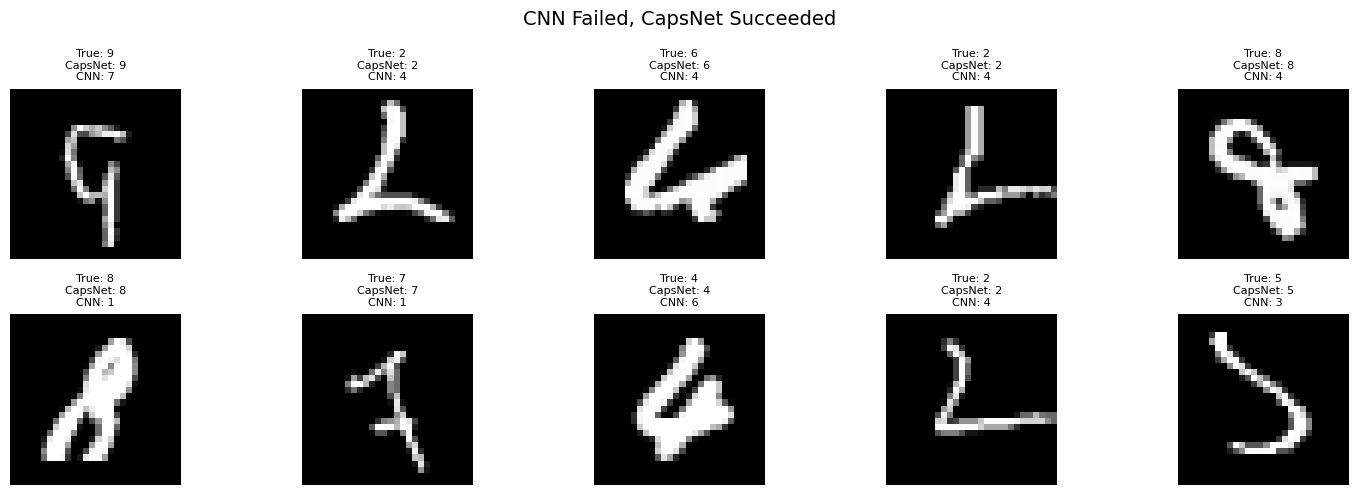

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Function to identify and visualize misclassified images
def visualize_misclassified(capsnet_model, cnn_model, x_test, y_test, num_images=10):
    """
    Visualizes misclassified examples where:
    1. CNN failed but CapsNet succeeded.
    2. CapsNet failed but CNN succeeded.

    Parameters:
        capsnet_model: Trained CapsNet model
        cnn_model: Trained CNN model
        x_test: Test dataset (input images)
        y_test: Test dataset (true labels, one-hot encoded)
        num_images: Number of examples to visualize for each case
    """
    # Get predictions from both models
    capsnet_predictions = np.argmax(capsnet_model.predict(x_test), axis=1)
    cnn_predictions = np.argmax(cnn_model.predict(x_test), axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Find misclassified indices
    cnn_failed_capsnet_succeeded = []  # CNN wrong, CapsNet correct
    capsnet_failed_cnn_succeeded = []  # CapsNet wrong, CNN correct

    for i in range(len(true_labels)):
        if cnn_predictions[i] != true_labels[i] and capsnet_predictions[i] == true_labels[i]:
            cnn_failed_capsnet_succeeded.append(i)
        elif capsnet_predictions[i] != true_labels[i] and cnn_predictions[i] == true_labels[i]:
            capsnet_failed_cnn_succeeded.append(i)

    # Visualization helper function
    def plot_examples(indices, title, model_name1, model_name2):
        """Helper function to plot examples."""
        plt.figure(figsize=(15, 5))
        for idx, image_idx in enumerate(indices[:num_images]):
            plt.subplot(2, num_images // 2, idx + 1)
            plt.imshow(x_test[image_idx].squeeze(), cmap='gray')
            plt.title(f"True: {true_labels[image_idx]}\n{model_name1}: {capsnet_predictions[image_idx]}\n{model_name2}: {cnn_predictions[image_idx]}", fontsize=8)
            plt.axis('off')
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()

    # Plot CNN failed, CapsNet succeeded
    plot_examples(
        cnn_failed_capsnet_succeeded,
        "CNN Failed, CapsNet Succeeded",
        "CapsNet",
        "CNN"
    )



# Call the function with your trained models
visualize_misclassified(capsnet_model=model, cnn_model=cnn_model, x_test=x_test, y_test=y_test, num_images=10)
